In [6]:
%pip install matplotlib
%pip install ultralytics

import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
%pwd


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


'/Users/amy/code/homeplate/homeplate/python'

In [7]:
import cv2
import numpy as np

def custom_home_plate_find(image_path):
    print(f"FileName {image_path}")
    
    mat_bgr = cv2.imread(image_path)
    
    if mat_bgr is None or mat_bgr.size == 0:
        print("NOT OPENED")
        return
    
    print(f"OPENED cols {mat_bgr.shape[1]} rows {mat_bgr.shape[0]}")
    find_home_plate(mat_bgr)

def find_home_plate(mat_bgr):
    b2k_image = False
    min_area = 300
    
    print(f"Image Width {mat_bgr.shape[1]} Height {mat_bgr.shape[0]}")
    
    if mat_bgr.shape[1] < 2600:
        mat_bgr = cv2.resize(mat_bgr, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    
    if mat_bgr.shape[1] < 2600:
        b2k_image = True
        min_area //= 2
    
    hsv_frame = cv2.cvtColor(mat_bgr, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 25, 180])
    upper_bound = np.array([30, 80, 255])
    
    hsv_frame = cv2.inRange(hsv_frame, lower_bound, upper_bound)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    hsv_frame = cv2.morphologyEx(hsv_frame, cv2.MORPH_OPEN, kernel)
    hsv_frame = cv2.morphologyEx(hsv_frame, cv2.MORPH_DILATE, kernel)
    hsv_frame = cv2.bitwise_not(hsv_frame)
    
    resize_image = cv2.resize(hsv_frame, None, fx=0.5, fy=0.5)
    cv2.imshow("Thresholded", resize_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    params = cv2.SimpleBlobDetector_Params()
    params.maxArea = 1200
    params.minThreshold = 254
    params.maxThreshold = 255
    params.minRepeatability = 1
    params.filterByArea = True
    params.minArea = min_area
    params.filterByCircularity = True
    params.minCircularity = 0.15
    params.maxCircularity = 0.40
    params.filterByConvexity = True
    params.minConvexity = 0.85
    params.maxConvexity = 1.0
    params.filterByInertia = False
    
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(hsv_frame)
    
    print(f"Keypoints found {len(keypoints)}")
    keypoint_list = [kp for kp in keypoints if verify_home_plate(hsv_frame, kp)]
    
    for key in keypoint_list:
        print(f"Keypoint found size {key.size} x {key.pt[0]} y {key.pt[1]} angle {key.angle}")
    
    image_with_keypoints = cv2.drawKeypoints(mat_bgr, keypoints, None, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image_with_keypoints = cv2.resize(image_with_keypoints, None, fx=0.5, fy=0.5)
    cv2.imshow("Found Blobs", image_with_keypoints)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def verify_home_plate(image, key):
    gray = image.copy()
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:
            area = cv2.contourArea(contour)
            if area > 300:
                rect = cv2.boundingRect(approx)
                cv2.rectangle(image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 4)
                print(f"Rectangle found, area {area}")
                if rect[2] > rect[3]:
                    print("*** Rectangle width > height")
    return True


def custom_process_light_index_hsv_value_baseball(mat_bgr):
    if mat_bgr.shape[1] < 2600:
        mat_bgr = cv2.resize(mat_bgr, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    
    mat_bgr_roi = mat_bgr[1800:mat_bgr.shape[0], 800:1600]
    mat_hsv = cv2.cvtColor(mat_bgr_roi, cv2.COLOR_BGR2HSV)
    
    hist = cv2.calcHist([mat_hsv], [2], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist, 1, 100, cv2.NORM_MINMAX)
    
    value_index = 200
    for i in range(256):
        if hist[i][0] >= 98:
            value_index = i
            break
    
    print(f"Index where value is 98: {value_index}")
    return value_index + 10



In [17]:
def find_home_plate(mat_bgr, hsv_value):
    b2k_image = False
    min_area = 300
    
    print(f"Image Width {mat_bgr.shape[1]} Height {mat_bgr.shape[0]}")
    
    if mat_bgr.shape[1] < 2600:
        mat_bgr = cv2.resize(mat_bgr, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    
    if mat_bgr.shape[1] < 2600:
        b2k_image = True
        min_area //= 2
    
    hsv_frame = cv2.cvtColor(mat_bgr, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 25, hsv_value])
    upper_bound = np.array([30, 70, 255])
    
    hsv_frame = cv2.inRange(hsv_frame, lower_bound, upper_bound)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    hsv_frame = cv2.morphologyEx(hsv_frame, cv2.MORPH_OPEN, kernel)
    hsv_frame = cv2.morphologyEx(hsv_frame, cv2.MORPH_DILATE, kernel)
    hsv_frame = cv2.bitwise_not(hsv_frame)
    
    resize_image = cv2.resize(hsv_frame, None, fx=0.5, fy=0.5)
    im_rgb = cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

    plt.axis('off')  # Hide axes
    plt.show()
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    params = cv2.SimpleBlobDetector_Params()
    params.maxArea = 1200
    params.minThreshold = 254
    params.maxThreshold = 255
    params.minRepeatability = 1
    params.filterByArea = True
    params.minArea = min_area
    params.filterByCircularity = True
    params.minCircularity = 0.15
    params.maxCircularity = 0.40
    params.filterByConvexity = True
    params.minConvexity = 0.85
    params.maxConvexity = 1.0
    params.filterByInertia = False
    
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(hsv_frame)
    
    print(f"Keypoints found {len(keypoints)}")
    keypoint_list = [kp for kp in keypoints if verify_home_plate(hsv_frame, kp)]
    
    for key in keypoint_list:
        print(f"Keypoint found size {key.size} x {key.pt[0]} y {key.pt[1]} angle {key.angle}")
    
    image_with_keypoints = cv2.drawKeypoints(mat_bgr, keypoints, None, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image_with_keypoints = cv2.resize(image_with_keypoints, None, fx=0.5, fy=0.5)
    im_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off')  # Hide axes
    plt.show()
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

def custom_process_light_index_hsv_value_baseball(mat_bgr):
    if mat_bgr.shape[1] < 2600:
        mat_bgr = cv2.resize(mat_bgr, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    
    mat_bgr_roi = mat_bgr[1800:mat_bgr.shape[0], 800:1600]
    mat_hsv = cv2.cvtColor(mat_bgr_roi, cv2.COLOR_BGR2HSV)
    
    hist = cv2.calcHist([mat_hsv], [2], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist, 1, 100, cv2.NORM_MINMAX)
    
    value_index = 200
    for i in range(256):
        if hist[i][0] >= 98:
            value_index = i
            break
    
    print(f"Index where value is 98: {value_index}")
    return value_index + 10

def verify_home_plate(image, key):
    gray = image.copy()
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:
            area = cv2.contourArea(contour)
            if area > 300:
                rect = cv2.boundingRect(approx)
                cv2.rectangle(image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 4)
                print(f"Rectangle found, area {area}")
                if rect[2] > rect[3]:
                    print("*** Rectangle width > height")
    return True

In [18]:
def find_home_plate_with_hsv_balancing(image_path):
    print(f"FileName {image_path}")
    
    mat_bgr = cv2.imread(image_path)
    
    if mat_bgr is None or mat_bgr.size == 0:
        print("NOT OPENED")
        return
    
    hsv_value = custom_process_light_index_hsv_value_baseball(mat_bgr)
    if hsv_value < 160:
        hsv_value = 160
    
    print(f"Calculated HSV Value: {hsv_value}")
    find_home_plate(mat_bgr, hsv_value)

def find_home_plate_with_hsv_balancing_from_mat(mat_bgr):    
    if mat_bgr is None or mat_bgr.size == 0:
        print("NOT OPENED")
        return
    
    hsv_value = custom_process_light_index_hsv_value_baseball(mat_bgr)
    if hsv_value < 160:
        hsv_value = 160
    
    print(f"Calculated HSV Value: {hsv_value}")
    find_home_plate(mat_bgr, hsv_value)


FileName ../images/test0.jpg
Index where value is 98: 100
Calculated HSV Value: 160
Image Width 4000 Height 2252


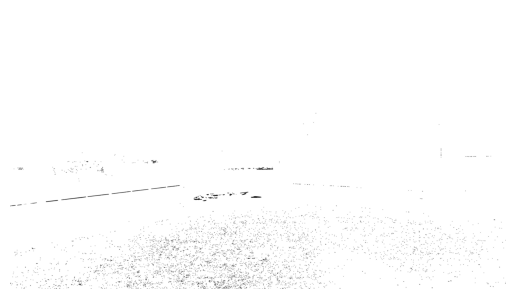

Keypoints found 3
Keypoint found size 51.00048065185547 x 338.4974365234375 y 1543.889404296875 angle -1.0
Keypoint found size 45.35636520385742 x 1984.103759765625 y 1512.24365234375 angle -1.0
Keypoint found size 34.1378059387207 x 1299.6773681640625 y 1426.9918212890625 angle -1.0


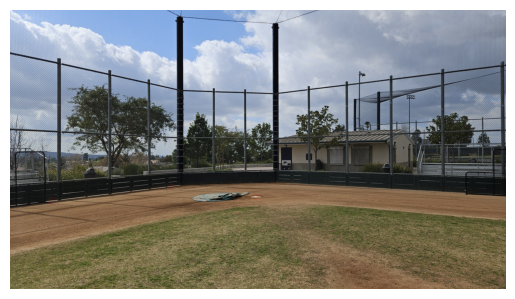

In [19]:
find_home_plate_with_hsv_balancing('../images/test0.jpg')

FileName ../images/test3.png
Index where value is 98: 147
Calculated HSV Value: 160
Image Width 1332 Height 996


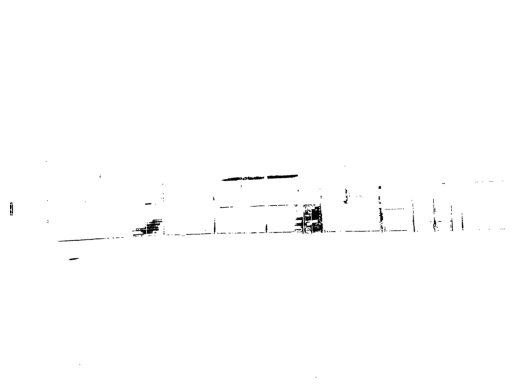

Keypoints found 2
Rectangle found, area 368.0
Rectangle found, area 1311.0
*** Rectangle width > height
Rectangle found, area 2233.0
*** Rectangle width > height
Rectangle found, area 4477.0
*** Rectangle width > height
Keypoint found size 29.70756721496582 x 342.2171630859375 y 1345.550048828125 angle -1.0
Keypoint found size 34.343563079833984 x 1101.2142333984375 y 1178.8089599609375 angle -1.0


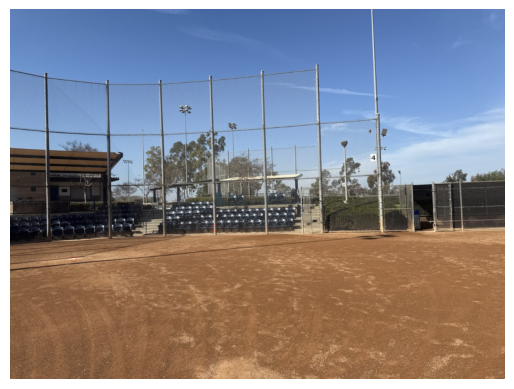

In [20]:
find_home_plate_with_hsv_balancing('../images/test3.png')

FileName ../images/test4.png
Index where value is 98: 200
Calculated HSV Value: 210
Image Width 1776 Height 986


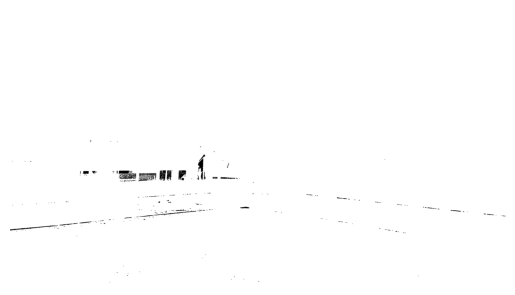

Keypoints found 5
Rectangle found, area 343.5
*** Rectangle width > height
Keypoint found size 28.166589736938477 x 380.6672058105469 y 1541.5361328125 angle -1.0
Keypoint found size 42.28981018066406 x 539.9049682617188 y 1524.5487060546875 angle -1.0
Keypoint found size 35.64512252807617 x 1682.0755615234375 y 1418.89404296875 angle -1.0
Keypoint found size 47.52750015258789 x 1545.833251953125 y 1207.584716796875 angle -1.0
Keypoint found size 19.883230209350586 x 1468.064208984375 y 1205.7891845703125 angle -1.0


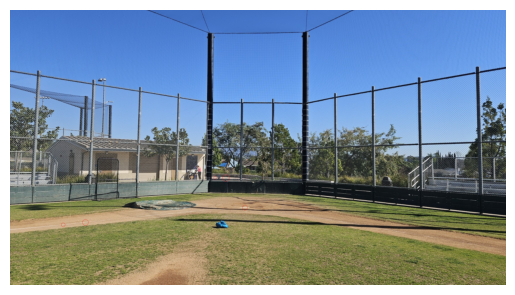

In [21]:
find_home_plate_with_hsv_balancing('../images/test4.png')

# White Balancing
Using histogram-based white balancing

In [22]:
def white_balance_histogram(image):
    b, g, r = cv2.split(image)

    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)
    r = cv2.equalizeHist(r)

    balanced_image = cv2.merge([b, g, r])
    return balanced_image




In [29]:
def show_image(im):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off')  # Hide axes
    plt.show()



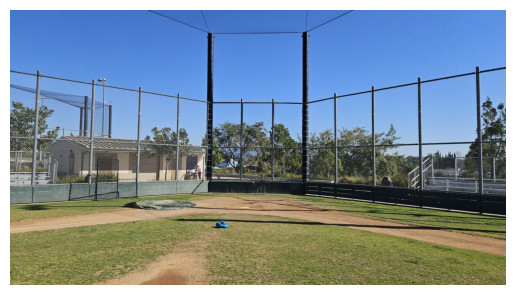

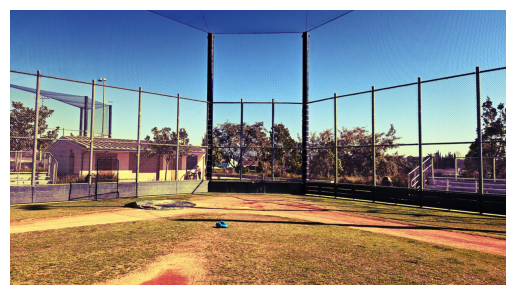

In [31]:
im = cv2.imread('../images/test4.png')
show_image(im)

white_balanced_image = white_balance_histogram(im)
show_image(white_balanced_image)

